### Description of dataset
* Dataset's name: [Daily Historical Stock Prices (1970 - 2018)](https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018)
* Description: Historical stock prices for several thousand unique stock tickers

### 1. Import findspark to read SPARK_HOME and HADOOP_HOME

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME
import findspark

findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark Clustering") \
    .getOrCreate()
# Print Spark object ID
print(spark)

In [3]:
df = spark.read.csv("D://Documents//Semester_8//Apache-Spark//historical_stock_prices.csv", header=True)

In [4]:
df.show()

+------+----------------+----------------+----------------+----------------+----------------+-------+----------+
|ticker|            open|           close|       adj_close|             low|            high| volume|      date|
+------+----------------+----------------+----------------+----------------+----------------+-------+----------+
|   AHH|            11.5|11.5799999237061|8.49315452575684|           11.25|11.6800003051758|4633900|2013-05-08|
|   AHH|11.6599998474121|11.5500001907349|8.47115135192871|            11.5|11.6599998474121| 275800|2013-05-09|
|   AHH|11.5500001907349|11.6000003814697|8.50782203674316|            11.5|11.6000003814697| 277100|2013-05-10|
|   AHH|11.6300001144409|11.6499996185303|8.54449367523193|11.5500001907349|11.6499996185303| 147400|2013-05-13|
|   AHH|11.6000003814697|11.5299997329712|8.45648384094238|            11.5|11.6000003814697| 184100|2013-05-14|
|   AHH|11.6000003814697|11.6000003814697|8.50782203674316| 11.539999961853|11.6000003814697|  7

In [5]:
df.count()

20973889

In [6]:
df.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- open: string (nullable = true)
 |-- close: string (nullable = true)
 |-- adj_close: string (nullable = true)
 |-- low: string (nullable = true)
 |-- high: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- date: string (nullable = true)



In [7]:
df.createOrReplaceTempView("stock")

### 2. Prepare dataset for clustering

In [8]:
df_num = df.select(df.ticker.cast("string"),
                   df.open.cast("float"),
                   df.close.cast("float"),
                   df.adj_close.cast("float"),
                   df.low.cast("float"),
                   df.high.cast("float"),
                   df.volume.cast("int"),
                   df.date.cast("date"))

In [9]:
df_num.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- open: float (nullable = true)
 |-- close: float (nullable = true)
 |-- adj_close: float (nullable = true)
 |-- low: float (nullable = true)
 |-- high: float (nullable = true)
 |-- volume: integer (nullable = true)
 |-- date: date (nullable = true)



In [10]:
df_num.createOrReplaceTempView("stock_num")

In [11]:
df_cluster = spark.sql("select `ticker`, avg(`open`), avg(`close`) \
            from stock_num \
            where `date` like '2017%' \
            group by `ticker` \
            order by `ticker` asc")

In [12]:
df_cluster.show()

+------+------------------+------------------+
|ticker|         avg(open)|        avg(close)|
+------+------------------+------------------+
|     A|59.322270837912995| 59.32968129009839|
|    AA| 38.25270930894342|38.301673304037266|
|  AABA| 56.45780884032231| 56.49183264196631|
|   AAL|47.498047710889836| 47.49071721536705|
|  AAME|3.6289565283319223|3.6226956543715105|
|   AAN| 36.58992027191527| 36.57764934828557|
|  AAOI| 53.21123504638672|53.216573806397946|
|  AAON| 34.98466139865587| 34.99262951094791|
|   AAP|122.74330631575262|122.57486071339642|
|  AAPL|150.44490045190332|150.55107548322334|
|   AAT|40.838207108091076| 40.81657373192776|
|   AAV| 6.087211140598434| 6.077091625487187|
|  AAWW| 57.03087649402391| 57.05115536389598|
|  AAXJ| 68.05378504293374| 68.06992036127949|
|  AAXN|24.090119555651903|24.105298768001724|
|    AB|23.712549855509604|23.730478096768202|
|  ABAC|2.6382470078677294| 2.629641426986907|
|  ABAX|48.509521864324924| 48.51896412154118|
|   ABB| 24.2

In [19]:
vecAssembler = VectorAssembler(
    inputCols=["avg(open)", "avg(close)"],
    outputCol="features")
data = vecAssembler.transform(df_cluster)
data.show()

+------+------------------+------------------+--------------------+
|ticker|         avg(open)|        avg(close)|            features|
+------+------------------+------------------+--------------------+
|     A|59.322270837912995| 59.32968129009839|[59.3222708379129...|
|    AA| 38.25270930894342|38.301673304037266|[38.2527093089434...|
|  AABA| 56.45780884032231| 56.49183264196631|[56.4578088403223...|
|   AAL|47.498047710889836| 47.49071721536705|[47.4980477108898...|
|  AAME|3.6289565283319223|3.6226956543715105|[3.62895652833192...|
|   AAN| 36.58992027191527| 36.57764934828557|[36.5899202719152...|
|  AAOI| 53.21123504638672|53.216573806397946|[53.2112350463867...|
|  AAON| 34.98466139865587| 34.99262951094791|[34.9846613986558...|
|   AAP|122.74330631575262|122.57486071339642|[122.743306315752...|
|  AAPL|150.44490045190332|150.55107548322334|[150.444900451903...|
|   AAT|40.838207108091076| 40.81657373192776|[40.8382071080910...|
|   AAV| 6.087211140598434| 6.077091625487187|[6

### 3. Simple Clustering

In [20]:
# Train Model
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(data)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[54.91665689 55.07530053]
[227976.92307692 228908.54700855]


In [21]:
# Make a prediction
predictions = model.transform(data)
predictions.show()

+------+------------------+------------------+--------------------+----------+
|ticker|         avg(open)|        avg(close)|            features|prediction|
+------+------------------+------------------+--------------------+----------+
|     A|59.322270837912995| 59.32968129009839|[59.3222708379129...|         0|
|    AA| 38.25270930894342|38.301673304037266|[38.2527093089434...|         0|
|  AABA| 56.45780884032231| 56.49183264196631|[56.4578088403223...|         0|
|   AAL|47.498047710889836| 47.49071721536705|[47.4980477108898...|         0|
|  AAME|3.6289565283319223|3.6226956543715105|[3.62895652833192...|         0|
|   AAN| 36.58992027191527| 36.57764934828557|[36.5899202719152...|         0|
|  AAOI| 53.21123504638672|53.216573806397946|[53.2112350463867...|         0|
|  AAON| 34.98466139865587| 34.99262951094791|[34.9846613986558...|         0|
|   AAP|122.74330631575262|122.57486071339642|[122.743306315752...|         0|
|  AAPL|150.44490045190332|150.55107548322334|[150.4

In [22]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9999804692864935


| k   | Silhouette score   |
| --- | :----------------: |
| 2   | 0.9999804692864935 |
| 3   | 0.999532875131843  |
| 5   | 0.9995817478006022 |
| 7   | 0.9990897286086486 |
| 9   | 0.9978445001328871 |
| 11  | 0.9978445001328871 |
| 13  | 0.9978445001328871 |

### 4. Visualization Cluster

In [23]:
# Import pixiedust to visualization cluster
import pixiedust


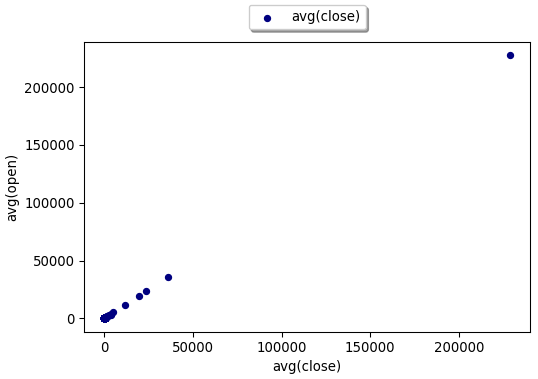

In [ ]:
display(predictions)

![cluster](images/cluster.png)